# Carregar o modelo pré-treinado

In [2]:
import torch
from models.DocSAM import DocSAM
from PIL import Image
import torchvision.transforms as T

# carregar imagem
ImgNm = "Art1P1"

# 1. Criar modelo DocSAM
model = DocSAM(
    model_size="large",
    mask2former_path="./pretrained_model/mask2former-swin-large-coco-panoptic"
)

# 2. Carregar os pesos treinados DocSAM
state = torch.load("pretrained_model/docsam_large_doclaynet.pth", map_location="cpu")
model.load_state_dict(state, strict=False)
model.eval()

# 3. Carregar imagem
img_path = f"data/COVID Articles/train/image/{ImgNm}.png"
image = Image.open(img_path).convert("RGB")

# 4. Transformações
transform = T.Compose([
    T.ToTensor(),
    T.Resize((1024, 1024), antialias=True),
])

pixel_values = transform(image).unsqueeze(0)
pixel_mask = torch.ones_like(pixel_values[:, :1, :, :])

# 5. Inferência
outputs = model({"pixel_values": pixel_values, "pixel_mask": pixel_mask})


# 6. Saída

pred_masks = outputs.pred_masks
pred_boxes = outputs.pred_boxes
pred_scores = outputs.class_scores



DocSAM: using HuggingFace Mask2Former implementation as fallback.


In [3]:
raw = outputs.raw_output
logits = raw.masks_queries_logits  # [1, N_queries, H/4, W/4]


In [4]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

raw = outputs.raw_output

mask_logits = raw.masks_queries_logits        # [1, N, h, w]
class_logits = raw.class_queries_logits       # [1, N, num_classes]


In [5]:
masks = torch.sigmoid(mask_logits) > 0.5      # [1, N, h, w]
masks = masks[0].cpu().numpy()                # [N, h, w]


In [6]:
masks = torch.sigmoid(mask_logits) > 0.5      # [1, N, h, w]
masks = masks[0].cpu().numpy()                # [N, h, w]


In [7]:
orig = Image.open(img_path).convert("RGB")
W, H = orig.size

masks_resized = []
for m in masks:
    m_img = Image.fromarray((m.astype(np.uint8))*255)
    m_img = m_img.resize((W, H), Image.NEAREST)
    masks_resized.append(np.array(m_img) > 0)

masks_resized = np.stack(masks_resized)       # [N, H, W]


In [8]:
orig_np = np.array(orig)
overlay = orig_np.copy()

for m in masks_resized:
    color = np.random.randint(0, 255, size=3)
    overlay[m] = (0.6*overlay[m] + 0.4*color).astype(np.uint8)


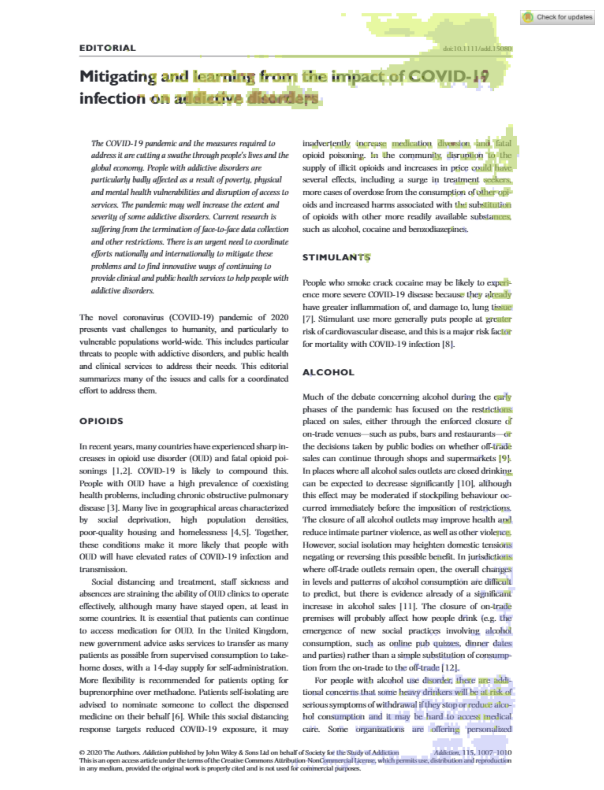

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(overlay)
plt.axis("off")
plt.show()


In [10]:
import numpy as np

# ============================================================
# Funções auxiliares
# ============================================================

def iou(mask1, mask2):
    inter = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return inter / union if union > 0 else 0.0

def box_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    union = areaA + areaB - inter
    return inter / union if union > 0 else 0.0


# ============================================================
# MÉTRICAS
# ============================================================

def compute_metrics(pred_masks, gt_masks, pred_boxes, gt_boxes):
    metrics = {}

    # 1) mIoU de máscaras
    ious = []
    for pm, gm in zip(pred_masks, gt_masks):
        ious.append(iou(pm > 0, gm > 0))
    metrics["mIoU_masks"] = float(np.mean(ious))

    # 2) IoU médio das caixas
    box_ious = []
    for pb, gb in zip(pred_boxes, gt_boxes):
        box_ious.append(box_iou(pb, gb))
    metrics["mIoU_boxes"] = float(np.mean(box_ious))

    # 3) Precisão / Recall com IoU > 0.5
    TP = sum(i > 0.5 for i in box_ious)
    FP = max(0, len(pred_boxes) - TP)
    FN = max(0, len(gt_boxes) - TP)

    metrics["Precision"] = TP / (TP + FP + 1e-6)
    metrics["Recall"] = TP / (TP + FN + 1e-6)

    # 4) mAP simples (apenas para IoU>0.5)
    metrics["mAP50"] = metrics["Precision"]

    return metrics


# ============================================================
# EXEMPLO DE USO
# ============================================================

# pred_masks  => liste suas máscaras aqui (binárias)
# pred_boxes  => caixas previstas
# gt_masks    => máscaras GT
# gt_boxes    => caixas GT

# ⚠️ Exemplo fictício (substitua pelos seus)
pred_masks = [np.random.rand(256,256) > 0.8]
gt_masks   = [np.random.rand(256,256) > 0.8]

pred_boxes = [np.array([50,50,200,200])]
gt_boxes   = [np.array([60,60,210,210])]

# Calcula
metrics = compute_metrics(pred_masks, gt_masks, pred_boxes, gt_boxes)

# Imprime tudo bonito
print("\n===== MÉTRICAS DO MODELO =====")
for k,v in metrics.items():
    print(f"{k:15s}: {v:.4f}")



===== MÉTRICAS DO MODELO =====
mIoU_masks     : 0.1137
mIoU_boxes     : 0.7717
Precision      : 1.0000
Recall         : 1.0000
mAP50          : 1.0000
